<a href="https://colab.research.google.com/github/marlapinkert/TEWA2/blob/main/04_Motion_Intro_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04 - Motion and Introduction to Preprocessing
In today's session, we will do our first steps in **preprocessing**. Specifically, we will look at how we deal with **motion** - and how to check how much our participants moved. We will use **Neurodesk** for these purposes.

Objectives:
- Creating an environment in Colab which allows us to access neuroimaging analysis software
- Learning how to find out whether participants moved too much
- Practicing the usage of Nipype interfaces


## Using Neurodesk
There are many different packages and software used to preprocess MRI data. Installing them locally can be complicated and frustrating. I remember in a preprocessing class I took, only a third of students was able to install FSL. As we want to spend our time analysing data, not troubleshooting installations, we will use a different solution: **Neurodesk**. Neurodesk provides us with an environment which already comes with all we need - no complicated set-up. I think it is a really cool project, see [here](https://www.neurodesk.org/) for more information.

The cell below installs neurodesk for us, and then also "installs" FSL, which we will need for today's analyses. Running it takes about one to two minutes.


In [ ]:
import os
os.environ["LD_PRELOAD"] = "";
os.environ["APPTAINER_BINDPATH"] = "/content"
os.environ["LMOD_CMD"] = "/usr/share/lmod/lmod/libexec/lmod"

!curl -J -O https://raw.githubusercontent.com/NeuroDesk/neurocommand/main/googlecolab_setup.sh
!chmod +x googlecolab_setup.sh
!./googlecolab_setup.sh
os.environ["MODULEPATH"] = ':'.join(map(str, list(map(lambda x: os.path.join(os.path.abspath('/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/'), x),os.listdir('/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/')))))

import lmod
await lmod.load('fsl/6.0.4')


We also download some data to work with. We will use the [NYU Slow Flanker dataset from Openneuro](https://openneuro.org/datasets/ds000102/versions/00001). In this study, healthy adults underwent MRI scanning while performing an event-related [Eriksen Flanker task](https://en.wikipedia.org/wiki/Eriksen_flanker_task). We specify `-d /data` so the data is saved in our data folder.

In [ ]:
# download dataset
!gdown 1YP7UtrbsFCCEYxvuY5D3DMiOh7pXyRWJ
!unzip /content/ds000102.zip -d /data

## FSL and MCFLIRT
**FSL** is a commonly used **library of analysis tools** for fMRI. It has a GUI, but can be used via the command line as well. We can use it for both preprocessing and first- and second-level analysis, however, we will use it for **preprocessing** only. Although you would often combine different tools, so you can cherry pick the best ones, it is completely possible to do every preprocessing step within FSL.

**MCFLIRT** is an FSL tool which we can use for **realigning** our functional data and calculation of **motion parameters**. We can not only run it using the command line, but also via a Nipype interface.

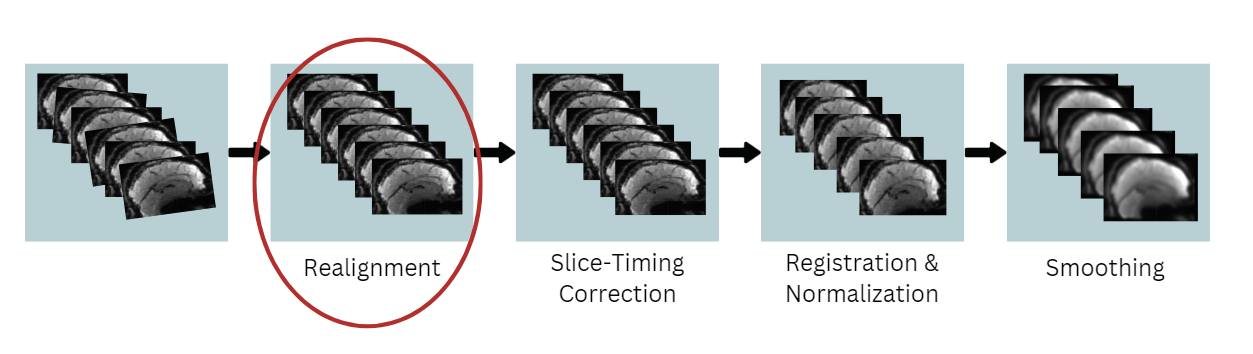

As usual, we start by checking which **flags** we can specify.

In [ ]:
!mcflirt

Now, we are ready to run **MCFLIRT** on the first run of our first subject. Additionally, we specify we want to save the "plots".

In [4]:
# change directory
%cd /data

# run mcflirt
!mcflirt -in ds000102/sub-01/func/sub-01_task-flanker_run-1_bold.nii.gz -plots

/data


In the `/func` folder of our first subject, two new files have appeared: `sub-01_task-flanker_run-1_bold_mcf.nii.gz` and `sub-01_task-flanker_run-1_bold_mcf.par`. The NIfTI file is our **realigned** functional file, the .par file contains our **motion parameters**!


## Plotting Motion Parameters
Now that we calculated our motion parameters, we can get to **plotting** them! First, we load them into memory using numpy, and have a look at their **shape**.

In [5]:
import numpy as np

motion_path = "ds000102/sub-01/func/sub-01_task-flanker_run-1_bold_mcf.par"
motion_parameters = np.loadtxt(motion_path)
print(f"Shape of motion parameter matrix: {motion_parameters.shape}")

Shape of motion parameter matrix: (146, 6)


A quick look at the shape of our motion parameters reveals that there are 146 timepoints and 6 parameters per timepoint. These 6 parameters concern 3 directions (**x, y, and z**) - the **translation**, and 3 angles in which the head can rotate (**pitch, yaw, and roll**) - the **rotation**.

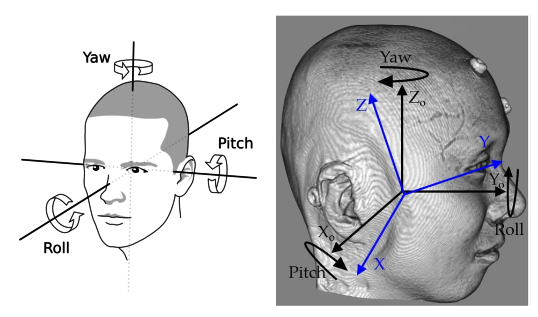

Let's have a look at the first 10 timepoints, and how they are represented in an array.

In [6]:
motion_parameters[:10,:]

array([[-0.00273076, -0.00276311, -0.00237603, -0.154286  ,  0.011919  ,
         0.0328879 ],
       [-0.00298859, -0.00262473, -0.00237603, -0.15885   ,  0.0274672 ,
         0.0875287 ],
       [-0.0029029 , -0.00255196, -0.00224164, -0.166514  ,  0.0269606 ,
         0.0997821 ],
       [-0.00252297, -0.00276311, -0.00237603, -0.166644  ,  0.0142047 ,
         0.0871495 ],
       [-0.00240446, -0.00270943, -0.00237603, -0.168801  , -0.00752524,
         0.0624465 ],
       [-0.00274884, -0.00258874, -0.00237603, -0.172638  ,  0.0512277 ,
         0.116354  ],
       [-0.00256525, -0.00251282, -0.00203235, -0.15235   , -0.0108426 ,
         0.0804987 ],
       [-0.00228808, -0.00276311, -0.00200398, -0.163281  ,  0.00232863,
         0.0529415 ],
       [-0.00252837, -0.00250916, -0.00224777, -0.165916  ,  0.00128811,
         0.0960623 ],
       [-0.00249458, -0.00276311, -0.00237603, -0.161301  ,  0.00757243,
         0.0870456 ]])

We now create two plots - the first one using the x, y, and z parameters, the second one using the pitch, yaw, and roll parameters. As you were able to see above, there are no labels to these arrays which tell us which parameter is which. This doesn't matter, as their order is always x, y, z, pitch, yaw, and roll

In [ ]:
import matplotlib.pyplot as plt

# Create plot
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,10))

# Plot motion parameters
axes[0].plot(motion_parameters[:, :3]) # x, y, z
axes[1].plot(motion_parameters[:, 3:]) # pitch, roll, yaw

# Add labels
axes[0].set_ylabel("translation (mm)")
axes[1].set_ylabel("rotation (radians)")
axes[1].set_xlabel("time (TR)")

axes[0].legend(["x","y","z"])
axes[1].legend(["pitch","roll","yaw"])

# Add main figure title
fig.suptitle(f"Subject 1, Flanker-Task Run 1: Motion Parameters",fontsize = 18)

plt.show()

In resting-state fMRI research, there are these approximate guidelines on "**what is too much motion**". They can be quite strict but still helpful as a reference:

- A mean framewise displacement above 0.2 mm.
- A maximum framewise displacement above 5 mm.
- An outlier percentage above 20%.

What do you think, just from looking at the motion plot - did this person move too much?

### Another example
Certain tasks can generate quite distinct movement patterns - look at this one, where participants had to exert effort in order to avoid painful stimuli. Pressing the dynamometer resulted in very distinct motion spikes! (The grey indicates the effort blocks). Do you think motion is a bigger problem in task-based fMRI or in resting-state fMRI?

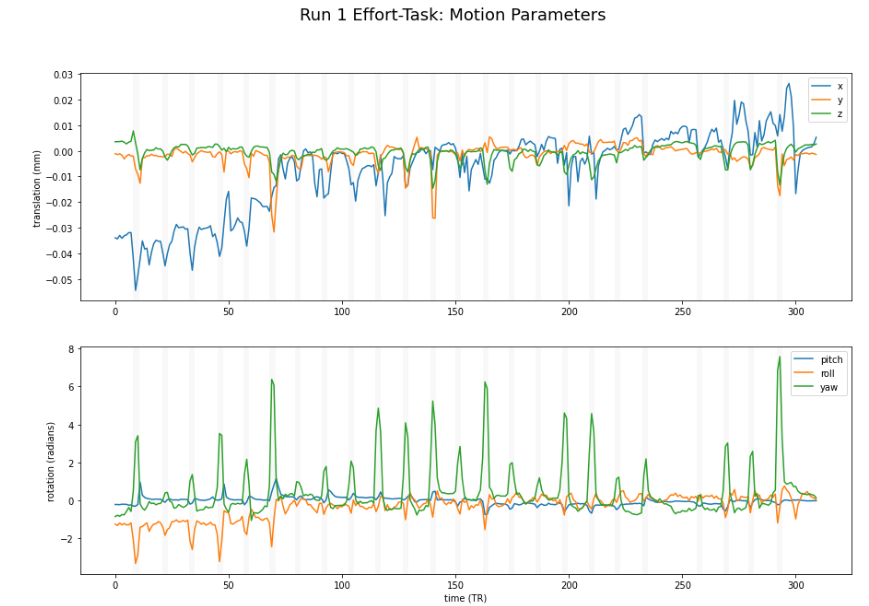

## Group Exercises

### 1. Exercise - MCFLIRT in Nipype
You might have wondered throughout this session: Where is Nipype? Weren't we supposed to use Nipype? The answer is yes. You will now use Nipype to perform motion correction for the first run of the second subject. Then, you can plot the motion parameters.

1. Use `fsl.MCFLIRT` to realign the functional file. Specify that you want to save your motion parameters. Call the output file `sub-02_task-flanker_run-1_bold_mcf.nii.gz`
2. Plot the motion parameters and give an estimate of whether you believe there is too much movement.

In [8]:
# run this cell to get the necessary packages
from nipype.interfaces import fsl
import nilearn
import nibabel

### 2. Additional Motion Parameters

So far, we have inspected all motion parameters visually. That is an important part of figuring out whether our participants moved too much. However, we can also calculate additional parameters - such as mean and maximum framewise displacement, and the amount of outliers. You can use `fsl.MotionOutliers`, which is a wrapper for the FSL tool `fsl_motion_outliers`, to calculate **mean & maximum framewise displacement**, as well as **outliers**. See [here](https://nipype.readthedocs.io/en/0.12.1/interfaces/generated/nipype.interfaces.fsl.utils.html#motionoutliers) for the documentation.

Your task is now to calculate the additional motion parameters for run 1 of subject 2.

When instantiating your object,

1. Specify "fdrms" as a `metric`,
2. Specify an output name for `out_metric_values` - it has to end in .par, and
3. Specify the name of your `out_file` - it has to end in .txt

Once you calculated the parameters, you can you `numpy.loadtxt()` to load in the two files. The `out_metric_values` file corresponds to the framewise displacement, and `out_file` to the outliers.

Calculate:
- Maximum framewise displacement (look for the max value ;))
- Mean framewise displacement
- The percentage of outliers

Based on these results, would you exclude the subject?